#### LIDAR Data Exploration, Processing, and Visualization
In this Ipython notebook, we provie scripts for data exploration, processing, and visualization of training data.

In [1]:
import torch
from torch.utils.data import Dataset
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


##### 1. Load LIDAR data and Convert 3D point cloud to 2D images
LIDAR data is represented by a 3D point cloud $(x_p, y_p, z_p)$. To reduce feature
dimensionality, the data is downsampled to a 2-dimensional grid of size [20, 200, 1] as seen
Further,  each pixel can be assigned to one of 4 possible values. That is we use values  1, 0, -1, -2 to represent the obstacle, empty space, Road Side Unit (RSU) and vehicle, respectively. 

In [4]:
lidar_data_path = './data/lidar_input/lidar_validation.npz'
lidar_data = np.load(lidar_data_path)['input']
lidar_data1 = np.zeros_like(lidar_data)[:, :, :, 1]  # By default, 0 represent the unoccupied spaces
lidar_data1[np.max(lidar_data == 1, axis=-1)] = 1    # occupied
lidar_data1[np.max(lidar_data == -2, axis=-1)] = -2  # vehicle
lidar_data1[np.max(lidar_data == -1, axis=-1)] = -1  # RSU
print('Input data shape: ', lidar_data.shape)  #(idx, x, y, z)
print('Downsample data shape: ', lidar_data1.shape) # simplified to 2D - (idx, x, y)

Input data shape:  (1960, 20, 200, 10)
Downsample data shape:  (1960, 20, 200)


##### Plot the 2D images in heatmap
We can identify the location of RSU, vehicles, and obstacles by corresponding color codes.

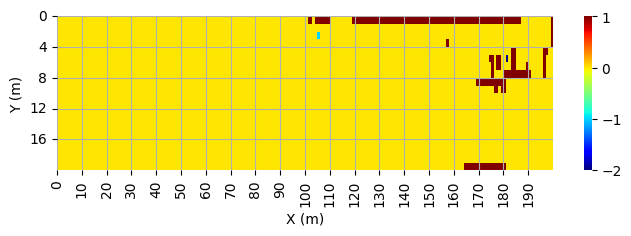

In [37]:
plt.figure(figsize = (8, 2))
ax =sns.heatmap(lidar_data1[100], cmap = 'jet',vmin=-2, vmax =1)
ax.set(xlabel="X (m)", ylabel="Y (m)")
plt.xticks(np.arange(0, 200, step= 10),np.arange(0, 200, step= 10))
plt.yticks(np.arange(0, 20, step= 4),np.arange(0, 20, step= 4))
plt.grid()
plt.show()

##### 2. Explore the Labels in the  Training Data

In [6]:
# A helper function for converting receiving power to dB and power clipping
def beams_log_scale(y, thresholdBelowMax):
    y_shape = y.shape
    for i in range(0, y_shape[0]):
        thisOutputs = y[i, :]
        logOut = 20 * np.log10(thisOutputs + 1e-30)  
        minValue = np.amax(logOut) - thresholdBelowMax
        zeroedValueIndices = logOut < minValue
        thisOutputs[zeroedValueIndices] = 0
        thisOutputs = thisOutputs / sum(thisOutputs)
        y[i, :] = thisOutputs
    return y

In [10]:
output_file = './data/beam_output/beams_output_train.npz'
thresholdBelowMax = 6  # (unit dB)
output_cache_file = np.load(output_file)
yMatrix = output_cache_file['output_classification']
print('yMatrix shape: ', yMatrix.shape)
#print(yMatrix[0])
yMatrix = np.abs(yMatrix)
yMatrix /= np.max(yMatrix)
num_classes = yMatrix.shape[1] * yMatrix.shape[2]

# Label transformation
y = np.zeros((yMatrix.shape[0], num_classes))
for i in range(0, yMatrix.shape[0], 1):  
    codebook = np.absolute(yMatrix[i, :])  
    Rx_size = codebook.shape[0]  # 8 antenna elements: vehicle
    Tx_size = codebook.shape[1]  # 32 antenna elements: RSU
    for tx in range(0, Tx_size, 1):
        for rx in range(0, Rx_size, 1):  
            y[i, tx * Rx_size + rx] = codebook[rx, tx]  
y = beams_log_scale(y, thresholdBelowMax)
print('y shape:', y.shape)

yMatrix shape:  (9234, 8, 32)
y shape: (9234, 256)


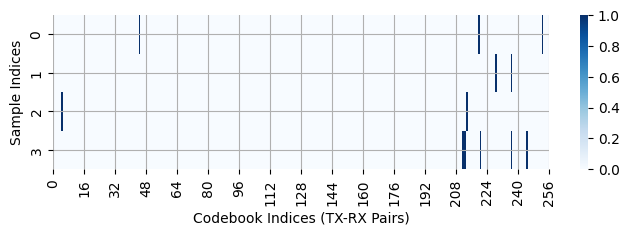

In [46]:
y_label = y.copy()
y_label[y_label>0] = 1
y_label_samples = y_label[0:4,:]
fig = plt.figure(figsize = (8, 2))
ax = sns.heatmap(y_label_samples, cmap = 'Blues')
plt.xlabel('Codebook Indices (TX-RX Pairs)')
plt.ylabel('Sample Indices')
plt.xticks(np.arange(0, 257, step= 16),np.arange(0, 257, step= 16) )
plt.grid()
plt.show()
